## Baseline Models
#### CSCI 4502 Final Project
#### Author: Ethan Meyer

In [2]:
import pandas as pd
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
# Load Tournament results and filter to year > 2008 (oldest moneyline data)
tournament_compact_results_df = pd.read_csv("../data//Kaggle-Data/MDataFiles_Stage1/MNCAATourneyCompactResults.csv")
tournament_compact_results_df = tournament_compact_results_df[tournament_compact_results_df['Season'] >= 2008]

moneyline_df = pd.read_csv("../data/Pre-Processed-Data/CleanedMoneylineData.csv",index_col=0)

In [4]:
tournament_compact_results_df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1456,2008,134,1291,69,1164,60,N,0
1457,2008,136,1181,71,1125,70,N,0
1458,2008,136,1242,85,1340,61,N,0
1459,2008,136,1243,80,1425,67,N,0
1460,2008,136,1266,74,1246,66,N,0


In [5]:
moneyline_df.head()

,Season,DayNum,TeamID,Moneyline
0,2008,0,1263,200.0
1,2008,0,1350,-240.0
2,2008,0,1404,13000.0
3,2008,0,1272,-39000.0
4,2008,1,1205,-160.0


In [6]:
winner_moneylines = pd.merge(tournament_compact_results_df, moneyline_df, how='left', 
                             left_on=['Season','DayNum','WTeamID'], 
                             right_on = ['Season','DayNum','TeamID'])[["Season", "DayNum", "WTeamID", "LTeamID","Moneyline"]]

winner_moneylines.rename(columns = {"Moneyline": "WMoneyline"}, inplace = True)

In [7]:
tournament_moneyline_df = pd.merge(winner_moneylines, moneyline_df, how='left', 
                             left_on=['Season','DayNum','LTeamID'], 
                             right_on = ['Season','DayNum','TeamID'])[["Season", "DayNum", "WTeamID", "LTeamID","WMoneyline","Moneyline"]]

tournament_moneyline_df.rename(columns = {"Moneyline": "LMoneyline"}, inplace = True)

tournament_moneyline_df.head()

,Season,DayNum,WTeamID,LTeamID,WMoneyline,LMoneyline
0,2008,134,1291,1164,-375.0,315.0
1,2008,136,1181,1125,-4500.0,2250.0
2,2008,136,1242,1340,-5000.0,2500.0
3,2008,136,1243,1425,140.0,-160.0
4,2008,136,1266,1246,-275.0,235.0


In [8]:
tournament_moneyline_df.isna().sum()

Season        0
DayNum        0
WTeamID       0
LTeamID       0
WMoneyline    0
LMoneyline    3
dtype: int64

In [9]:
# For now, drop NAs
tournament_moneyline_df = tournament_moneyline_df.dropna()

#### Determining implied probability

In [10]:
def calc_implied_p(moneyline):
    if moneyline < 0:
        return (-1*(moneyline)) / (-1*(moneyline) + 100)
    else:
        return 100 / (moneyline + 100)
    
def calc_net_payout(moneyline, amount_bet = 1):
    if moneyline < 0:
        return -amount_bet*(100/moneyline)
    else:
        return amount_bet*(moneyline/100)


In [11]:
tournament_probability_df = tournament_moneyline_df
tournament_probability_df["WTeam_Win%"] = tournament_probability_df["WMoneyline"].apply(calc_implied_p)
tournament_probability_df["LTeam_Win%"] = tournament_probability_df["LMoneyline"].apply(calc_implied_p)

tournament_probability_df.head()

,Season,DayNum,WTeamID,LTeamID,WMoneyline,LMoneyline,WTeam_Win%,LTeam_Win%
0,2008,134,1291,1164,-375.0,315.0,0.789474,0.240964
1,2008,136,1181,1125,-4500.0,2250.0,0.978261,0.042553
2,2008,136,1242,1340,-5000.0,2500.0,0.980392,0.038462
3,2008,136,1243,1425,140.0,-160.0,0.416667,0.615385
4,2008,136,1266,1246,-275.0,235.0,0.733333,0.298507


#### Strategy 1: Always bet 1 unit on favorite

In [12]:
def bet_favorite(df):
    initial_investment = len(df.index) # 1 unit for every game
    running_balance = initial_investment
    num_correct = 0
    
    for idx, row in df.iterrows():
        if row["WTeam_Win%"] > row["LTeam_Win%"]: # The favorite was the winning team 
            running_balance += calc_net_payout(row["WMoneyline"])
            num_correct += 1
        else: # The favorite was the losing team
            running_balance -= 1

    bet_favorite_ROI = (running_balance - initial_investment)/initial_investment
    accuracy = num_correct / initial_investment
    
    return bet_favorite_ROI, accuracy

#### Strategy 2: Always bet 1 unit on underdog

In [13]:
def bet_underdog(df):
    initial_investment = len(df.index) # 1 unit for every game
    running_balance = initial_investment
    num_correct = 0
    
    for idx, row in df.iterrows():
        if row["WTeam_Win%"] < row["LTeam_Win%"]: # The underdog was the winning team 
            running_balance += calc_net_payout(row["WMoneyline"])
            num_correct += 1
        else: # The favorite was the losing team
            running_balance -= 1

    bet_underdog_ROI = (running_balance - initial_investment)/initial_investment 
    accuracy = num_correct / initial_investment
    
    return bet_underdog_ROI, accuracy

#### Strategy 3: Bet 1 unit in alignment with random choice based on implied win%

In [14]:
def bet_mixed(df, n_iter=30):
    ROI_tracker = np.empty(n_iter)
    accuracy_tracker = np.empty(n_iter)
    
    for trial_num in range(n_iter): # Conduct several trials to reduce chance
        
        initial_investment = len(df.index) # 1 unit for every game
        running_balance = initial_investment
        num_correct = 0
        
        for idx, row in df.iterrows():
            normalized_p_win = row["WTeam_Win%"]/(row["WTeam_Win%"] + row["LTeam_Win%"])
            normalized_p_lose = row["LTeam_Win%"]/(row["WTeam_Win%"] + row["LTeam_Win%"])
            bet_on = np.random.choice(["winner","loser"], p=[normalized_p_win,normalized_p_lose])
            if bet_on == "winner":
                running_balance += calc_net_payout(row["WMoneyline"])
                num_correct += 1
            else:
                running_balance -= 1

        bet_mixed_ROI = (running_balance - initial_investment)/initial_investment
        accuracy = num_correct / initial_investment
        
        ROI_tracker[trial_num] = bet_mixed_ROI
        accuracy_tracker[trial_num] = accuracy
    
    return np.mean(ROI_tracker), np.mean(accuracy_tracker)
                                                    

### Strategy comparisson

In [15]:
list_of_years = np.unique(tournament_probability_df["Season"])
favorite_ROI_tracker = []
favorite_accuracy_tracker = []
underdog_ROI_tracker = []
underdog_accuracy_tracker = []
mixed_ROI_tracker = []
mixed_accuracy_tracker = []

for year in list_of_years:
    year_df = tournament_probability_df[tournament_probability_df["Season"] == year]
    
    fav_results = bet_favorite(year_df)
    favorite_ROI_tracker.append(fav_results[0])
    favorite_accuracy_tracker.append(fav_results[1])
    
    underdog_results = bet_underdog(year_df)
    underdog_ROI_tracker.append(underdog_results[0])
    underdog_accuracy_tracker.append(underdog_results[1])
    
    mixed_results = bet_mixed(year_df)
    mixed_ROI_tracker.append(mixed_results[0])
    mixed_accuracy_tracker.append(mixed_results[1])
    

In [16]:
dummy_results = pd.DataFrame({"Favorite Acc":favorite_accuracy_tracker,
                             "Favorite ROI":favorite_ROI_tracker,
                             "Underdog Acc":underdog_accuracy_tracker,
                             "Underdog ROI": underdog_ROI_tracker,
                             "Mixed Acc": mixed_accuracy_tracker,
                             "Mixed ROI":mixed_ROI_tracker})

In [17]:
dummy_results.to_csv("../data/Results-Data/dummy-performance.csv")

# Visualizations

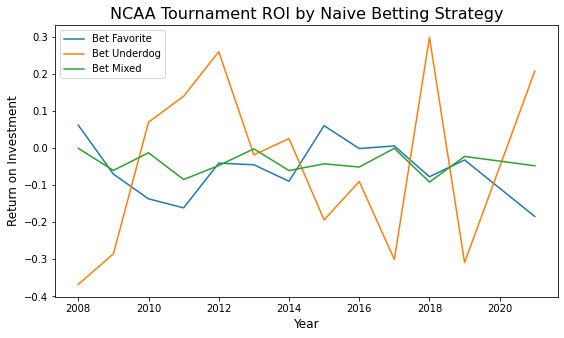

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))

plt.plot(list_of_years, favorite_ROI_tracker, label = "Bet Favorite")
plt.plot(list_of_years, underdog_ROI_tracker, label = "Bet Underdog")
plt.plot(list_of_years, mixed_ROI_tracker, label = "Bet Mixed")
plt.title("NCAA Tournament ROI by Naive Betting Strategy", size = 16)
plt.xlabel("Year", size = 12)
plt.ylabel("Return on Investment", size = 12)
plt.legend()
plt.show()

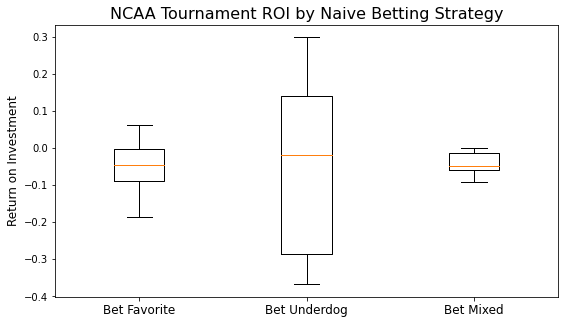

In [17]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.boxplot([favorite_ROI_tracker, underdog_ROI_tracker, mixed_ROI_tracker])
ax.set_xticklabels(['Bet Favorite', 'Bet Underdog', 'Bet Mixed'], size = 12)
ax.set_ylabel("Return on Investment", size = 12)
ax.set_title("NCAA Tournament ROI by Naive Betting Strategy", size =16);


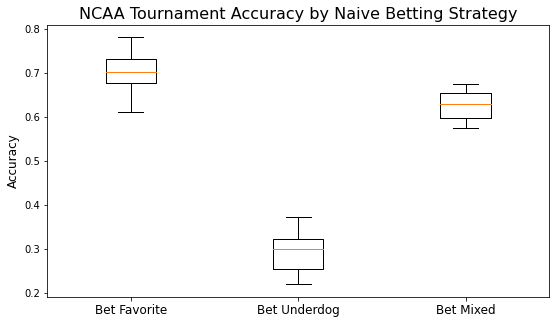

In [18]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.boxplot([favorite_accuracy_tracker, underdog_accuracy_tracker, mixed_accuracy_tracker])
ax.set_xticklabels(['Bet Favorite', 'Bet Underdog', 'Bet Mixed'], size = 12)
ax.set_ylabel("Accuracy", size = 12)
ax.set_title("NCAA Tournament Accuracy by Naive Betting Strategy", size =16);

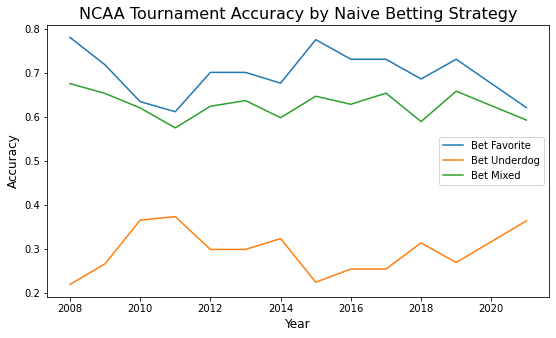

In [19]:
plt.figure(figsize=(9, 5))

plt.plot(list_of_years, favorite_accuracy_tracker, label = "Bet Favorite")
plt.plot(list_of_years, underdog_accuracy_tracker, label = "Bet Underdog")
plt.plot(list_of_years, mixed_accuracy_tracker, label = "Bet Mixed")
plt.title("NCAA Tournament Accuracy by Naive Betting Strategy", size = 16)
plt.xlabel("Year", size = 12)
plt.ylabel("Accuracy", size = 12)
plt.legend()
plt.show()

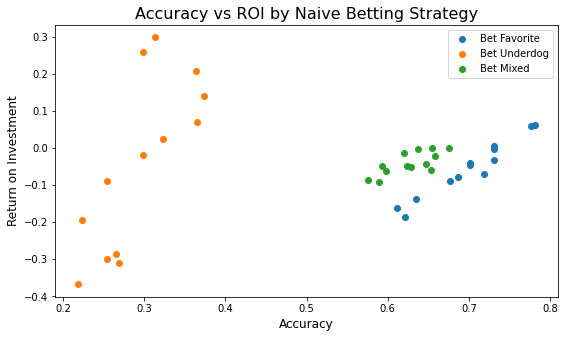

In [20]:
plt.figure(figsize=(9, 5))
plt.scatter(favorite_accuracy_tracker, favorite_ROI_tracker, label="Bet Favorite")
plt.scatter(underdog_accuracy_tracker, underdog_ROI_tracker, label="Bet Underdog")
plt.scatter(mixed_accuracy_tracker, mixed_ROI_tracker, label="Bet Mixed")
plt.title("Accuracy vs ROI by Naive Betting Strategy", size = 16)
plt.xlabel("Accuracy", size = 12)
plt.ylabel("Return on Investment", size = 12)
plt.legend()
plt.show()

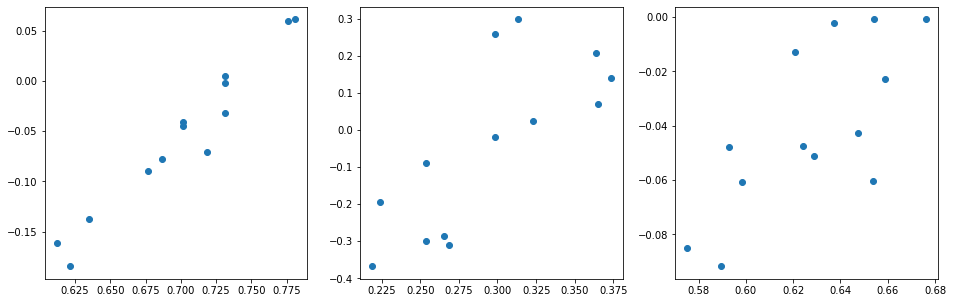

In [21]:
fig, axes = plt.subplots(1,3,figsize=(16, 5))

axes[0].scatter(favorite_accuracy_tracker, favorite_ROI_tracker)
axes[1].scatter(underdog_accuracy_tracker, underdog_ROI_tracker)
axes[2].scatter(mixed_accuracy_tracker, mixed_ROI_tracker)

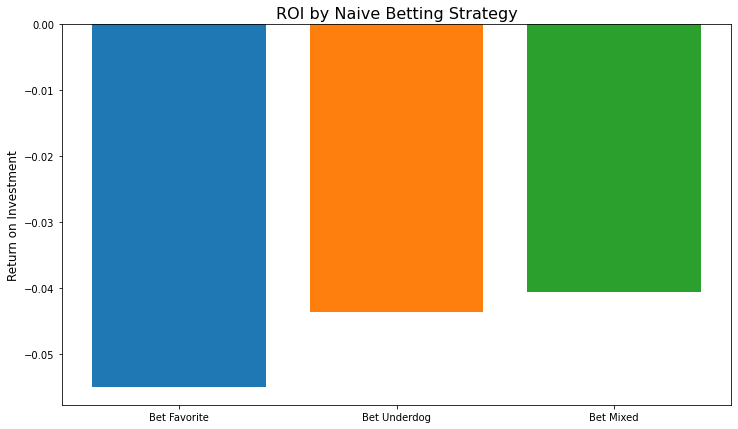

In [22]:
plt.figure(figsize=(12, 7))

plt.bar(['Bet Favorite', 'Bet Underdog', 'Bet Mixed'], 
        [np.mean(favorite_ROI_tracker), np.mean(underdog_ROI_tracker), np.mean(mixed_ROI_tracker)],
        color=['C0', 'C1', 'C2'])

plt.title("ROI by Naive Betting Strategy", size = 16)
plt.ylabel("Return on Investment", size = 12)
plt.show()

### Regular Season Games

In [23]:
regular_season_compact_results_df = pd.read_csv("../data//Kaggle-Data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
regular_season_compact_results_df = regular_season_compact_results_df[regular_season_compact_results_df['Season'] >= 2008]



In [24]:
winner_moneylines = pd.merge(regular_season_compact_results_df, moneyline_df, how='left', 
                             left_on=['Season','DayNum','WTeamID'], 
                             right_on = ['Season','DayNum','TeamID'])[["Season", "DayNum", "WTeamID", "LTeamID","Moneyline"]]

winner_moneylines.rename(columns = {"Moneyline": "WMoneyline"}, inplace = True)

In [25]:
tournament_moneyline_df = pd.merge(winner_moneylines, moneyline_df, how='left', 
                             left_on=['Season','DayNum','LTeamID'], 
                             right_on = ['Season','DayNum','TeamID'])[["Season", "DayNum", "WTeamID", "LTeamID","WMoneyline","Moneyline"]]

tournament_moneyline_df.rename(columns = {"Moneyline": "LMoneyline"}, inplace = True)

tournament_moneyline_df.head()

,Season,DayNum,WTeamID,LTeamID,WMoneyline,LMoneyline
0,2008,0,1272,1404,-39000.0,13000.0
1,2008,0,1350,1263,-240.0,200.0
2,2008,1,1205,1105,-160.0,140.0
3,2008,1,1246,1146,-7000.0,3000.0
4,2008,1,1272,1350,-10000.0,4000.0


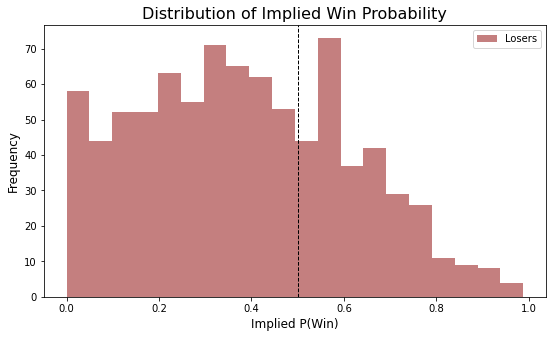

In [29]:
plt.figure(figsize=(9, 5))
plt.hist(tournament_probability_df["LTeam_Win%"], bins =20, facecolor='darkred', alpha=0.5, label="Losers")
plt.axvline(0.5, color='k', linestyle='dashed', linewidth=1)

plt.title("Distribution of Implied Win Probability", size = 16)
plt.xlabel("Implied P(Win)", size = 12)
plt.ylabel("Frequency", size = 12)
plt.legend()
plt.show()


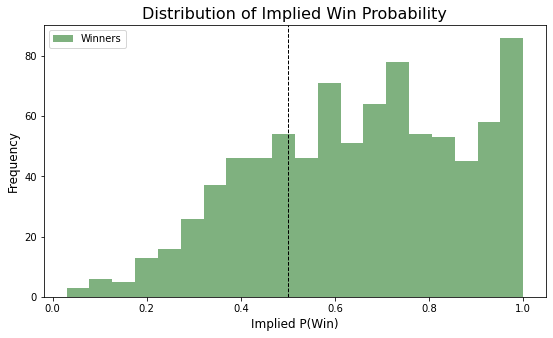

In [30]:
plt.figure(figsize=(9, 5))
plt.hist(tournament_probability_df["WTeam_Win%"], bins =20, facecolor='darkgreen', alpha=0.5, label="Winners")
plt.title("Distribution of Implied Win Probability", size = 16)
plt.axvline(0.5, color='k', linestyle='dashed', linewidth=1)

plt.xlabel("Implied P(Win)", size = 12)
plt.ylabel("Frequency", size = 12)
plt.legend()
plt.show()
